# 1. Download Training Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import requests

In [38]:
# Connect to Binance api to download training data, no need for keys or authentication, 
# but only accessible from physical machines(does not work on Google Cloud)

root_url = 'https://api.binance.com/api/v3/'

check_url = root_url + 'ping'

if requests.get(check_url).ok != True:
    print('!= 200')


In [39]:
# set api parameters including trading pairs, intervals, and desired timeframes

symbol = 'BTCUSDT' # 'BTCUSDT', 'ETHUSDT', etc.

interval = '1m' # '1m', '1h', '1d'

kline_url = root_url + 'klines'

params = {'interval':interval,
          'symbol':symbol,
          'endTime':1698796800000,
          #'limit':5 # Binance default: 500, max: 1000
         }

In [40]:
# get api data as json

if requests.get(url=kline_url, params=params).ok != True:
    print('Issue with Binance kline API connectivity, did not fetch data')

api_data = requests.get(url=kline_url, params=params).json()

In [41]:
# save json to dataframe

df = pd.DataFrame(api_data)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
          'k_close_time', 'quote_asset_volume', 'num_trades',
          'taker_base_vol', 'taker_quote_vol', 'ignore']

In [42]:
# use for loop to overcome Binance api max limit of 1000 rows per call

for i in range(1):
    prev = df['Date'][0]
    # url_next = url + '&endTime=' + str(prev)
    params['endTime'] = str(prev)
    next_data = requests.get(url=kline_url, params=params).json()
    df_next = pd.DataFrame(next_data)
    df_next.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
          'k_close_time', 'quote_asset_volume', 'num_trades',
          'taker_base_vol', 'taker_quote_vol', 'ignore']
    df = pd.concat([df_next, df]).drop_duplicates()


In [43]:
for col in ['Open', 'High', 'Low', 'Close', 'Volume',
            'quote_asset_volume', 'num_trades',
            'taker_base_vol', 'taker_quote_vol', 'ignore']:
    df[col] = df[col].astype(float)
    
df['Date'] = pd.to_datetime(df['Date'],unit='ms')

In [44]:
df

,Date,Open,High,Low,Close,Volume,k_close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol,ignore
0,2023-10-31 07:22:00,34251.98,34251.99,34240.57,34240.58,8.09643,1698736979999,2.773084e+05,468.0,1.84564,63212.847501,0.0
1,2023-10-31 07:23:00,34240.57,34243.99,34166.67,34179.26,63.16500,1698737039999,2.160254e+06,2142.0,16.01178,547505.884313,0.0
2,2023-10-31 07:24:00,34179.26,34199.65,34179.25,34197.08,23.44053,1698737099999,8.014693e+05,1201.0,13.29687,454617.512692,0.0
3,2023-10-31 07:25:00,34197.08,34213.57,34180.46,34213.56,21.11683,1698737159999,7.220398e+05,1396.0,11.28853,385968.060392,0.0
4,2023-10-31 07:26:00,34213.56,34213.57,34159.71,34175.97,97.01270,1698737219999,3.315378e+06,1846.0,25.78075,880944.891193,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2023-10-31 23:56:00,34647.33,34647.33,34632.64,34642.58,19.42605,1698796619999,6.729687e+05,801.0,8.26838,286419.908757,0.0
496,2023-10-31 23:57:00,34642.57,34658.35,34642.57,34658.34,31.23002,1698796679999,1.082139e+06,817.0,28.41668,984658.040357,0.0
497,2023-10-31 23:58:00,34658.34,34658.35,34658.34,34658.34,13.16276,1698796739999,4.561995e+05,359.0,10.06236,348744.794706,0.0
498,2023-10-31 23:59:00,34658.35,34658.35,34639.77,34639.77,18.62235,1698796799999,6.452150e+05,718.0,6.22231,215549.487531,0.0


In [45]:
# saving to csv

filename = f'{symbol}_{interval}.csv'
df.to_csv(f'../raw_data/{filename}')

# 2. Load Data & Packages

In [46]:
# Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error,  r2_score, accuracy_score
from sklearn.model_selection import train_test_split


In [47]:
# Read data from the CSV file into a DataFrame
data = pd.read_csv("../raw_data/BTCUSDT_1m.csv")
print(data.head(0))

# Select specific columns from the DataFrame
data = data.loc[:,['Date','Open','High','Low','Close','Volume']]

Empty DataFrame
Columns: [Unnamed: 0, Date, Open, High, Low, Close, Volume, k_close_time, quote_asset_volume, num_trades, taker_base_vol, taker_quote_vol, ignore]
Index: []


In [48]:
# Set the 'Date' column as the index of the DataFrame

data = data.set_index('Date')

data

,Open,High,Low,Close,Volume
Date,,,,,
2023-10-31 07:22:00,34251.98,34251.99,34240.57,34240.58,8.09643
2023-10-31 07:23:00,34240.57,34243.99,34166.67,34179.26,63.16500
2023-10-31 07:24:00,34179.26,34199.65,34179.25,34197.08,23.44053
2023-10-31 07:25:00,34197.08,34213.57,34180.46,34213.56,21.11683
2023-10-31 07:26:00,34213.56,34213.57,34159.71,34175.97,97.01270
...,...,...,...,...,...
2023-10-31 23:56:00,34647.33,34647.33,34632.64,34642.58,19.42605
2023-10-31 23:57:00,34642.57,34658.35,34642.57,34658.34,31.23002
2023-10-31 23:58:00,34658.34,34658.35,34658.34,34658.34,13.16276


# 3. Preprocess Data

In [49]:
#Set the Target column
aim = 'Close'

In [70]:
# 90-10 validation split
val_split_index = int(len(data) * 0.9)
val_data = data.iloc[val_split_index:]
available_data = data.iloc[:val_split_index]

# 80-20 validation split
split_index = int(len(available_data) * 0.8)
train_data = available_data.iloc[:split_index]
test_data = available_data.iloc[split_index:]


def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    """
    Create a line plot with two lines.
    Parameters:
    - line1 (array-like): Data for the first line.
    - line2 (array-like): Data for the second line.
    - label1 (str, optional): Label for the first line (default is None).
    - label2 (str, optional): Label for the second line (default is None).
    - title (str, optional): Title of the plot (default is an empty string).
    - lw (int, optional): Line width for both lines (default is 2).
    """
    # Create a subplot with specified size
    fig, ax = plt.subplots(1, figsize=(13, 7))

    # Plot the first line with its label
    ax.plot(line1, label=label1, linewidth=lw)

    # Plot the second line with its label
    ax.plot(line2, label=label2, linewidth=lw)

    # Set y-axis label
    ax.set_ylabel('BTC/USDT', fontsize=14)

    # Set the title
    ax.set_title(title, fontsize=16)

    # Add a legend at the best location with the specified font size
    ax.legend(loc='best', fontsize=16)

    # Display the plot
    plt.show()


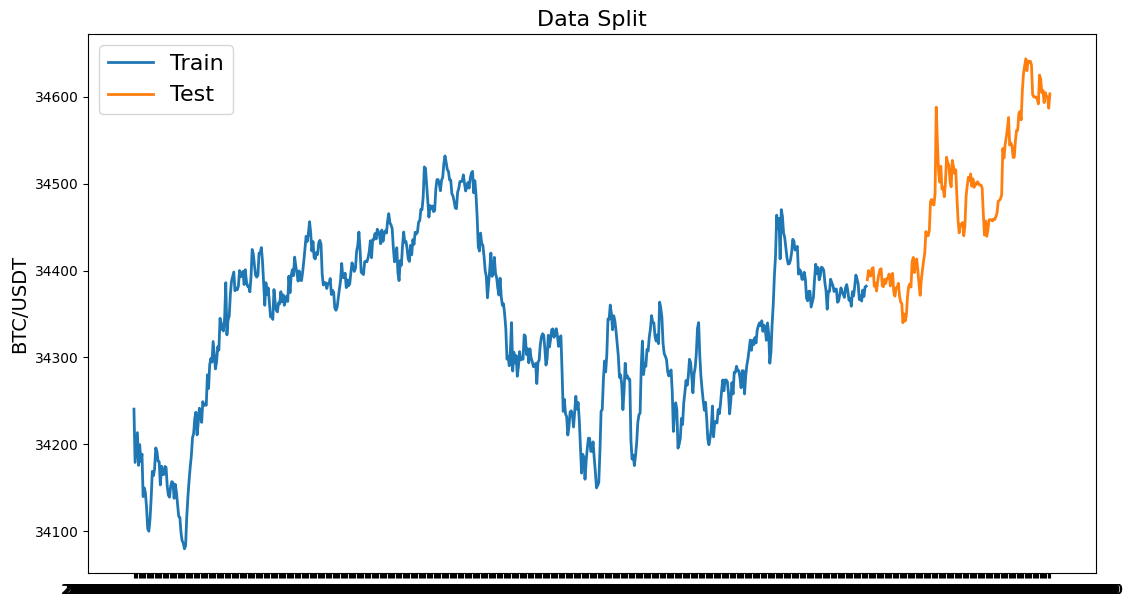

In [61]:
# Plotting the training and testing data for the 'Close' column
line_plot(train_data[aim], test_data[aim], label1='Train', label2='Test', title='Data Split')


In [52]:
# Function to normalize a continuous variable to a zero-base scale
def normalise_zero_base(continuous):
    """
    Normalize a continuous variable to a zero-base scale.
    Parameters:
    - continuous (pandas.Series): The continuous variable to be normalized.
    Returns:
    - pandas.Series: The normalized continuous variable.
    """
    # Normalize by dividing each value by the first value and subtracting 1
    return continuous / continuous.iloc[0] - 1


# Function to normalize a continuous variable to a min-max scale
def normalise_min_max(continuous):
    """
    Normalize a continuous variable to a min-max scale.
    Parameters:
    - continuous (pandas.Series): The continuous variable to be normalized.
    Returns:
    - pandas.Series: The normalized continuous variable.
    """
    # Normalize using min-max scaling formula
    return (continuous - continuous.min()) / (continuous.max() - continuous.min())


In [53]:
# Function to extract windowed data from a continuous variable
def extract_window_data(continuous, window_len=5, zero_base=True):
    """
    Extract windowed data from a continuous variable.
    Parameters:
    - continuous (pandas.Series): The continuous variable to extract windows from.
    - window_len (int, optional): The length of each window (default is 5).
    - zero_base (bool, optional): Whether to normalize each window to a zero-base scale (default is True).
    Returns:
    - numpy.ndarray: Array of windowed data.
    Example:
    >>> windowed_data = extract_window_data(data['Close'], window_len=10, zero_base=True)
    """
    # Initialize an empty list to store windowed data
    window_data = []

    # Iterate over the continuous variable to extract windows
    for idx in range(len(continuous) - window_len):
        # Extract a window of data
        tmp = continuous[idx: (idx + window_len)].copy()

        # Normalize the window to a zero-base scale if specified
        if zero_base:
            tmp = normalise_zero_base(tmp)

        # Append the window data to the list
        window_data.append(tmp.values)

    # Convert the list of windowed data to a numpy array
    return np.array(window_data)


In [54]:
# Function to prepare data for time series analysis
def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    """
    Prepare data for time series analysis.
    Parameters:
    - continuous (pandas.Series): The continuous variable for time series analysis.
    - aim (str): The target variable to predict.
    - window_len (int, optional): The length of each window (default is 10).
    - zero_base (bool, optional): Whether to normalize each window to a zero-base scale (default is True).
    - test_size (float, optional): The proportion of data to be used as the test set (default is 0.2).
    Returns:
    - tuple: A tuple containing train_data, test_data, X_train, X_test, y_train, y_test.
    """
    # Extract windowed data for training and testing sets
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)

    # Extract target variable for training and testing sets
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values

    # Normalize the target variable to a zero-base scale if specified
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    # Return the prepared data
    return train_data, test_data, X_train, X_test, y_train, y_test


# 4. LSTM Model

In [55]:
# Function to build an LSTM (Long Short-Term Memory) model# Function to build an LSTM (Long Short-Term Memory) model
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    """
    Build an LSTM (Long Short-Term Memory) model.
    Parameters:
    - input_data (numpy.ndarray): The input data for the model.
    - output_size (int): The size of the output layer.
    - neurons (int): The number of neurons in the LSTM layer.
    - activ_func (str, optional): Activation function for the output layer (default is 'linear').
    - dropout (float, optional): Dropout rate to prevent overfitting (default is 0.2).
    - loss (str, optional): Loss function for model training (default is 'mse' - Mean Squared Error).
    - optimizer (str, optional): Optimization algorithm for model training (default is 'adam').
    Returns:
    - tensorflow.keras.models.Sequential: The constructed LSTM model.
    """
    # Create a Sequential model
    model = Sequential()

    # Add an LSTM layer with the specified number of neurons and input shape
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))

    # Add a Dropout layer to prevent overfitting
    model.add(Dropout(dropout))

    # Add a Dense layer with the specified number of units
    model.add(Dense(units=output_size))

    # Add an Activation layer with the specified activation function
    model.add(Activation(activ_func))

    # Compile the model with the specified loss function and optimizer
    model.compile(loss=loss, optimizer=optimizer)

    # Return the constructed LSTM model
    return model


In [57]:
# Define parameters for data preparation and LSTM model
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'
output_size = 1

# Prepare data for time series analysis
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [58]:
print(X_train.shape)


(794, 5, 5)


In [22]:
# Build an LSTM model
model = build_lstm_model(
    X_train, output_size=output_size, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)

# Train the LSTM model
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)


2023-12-29 09:12:37.743425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
38/38 [==============================] - 4s 21ms/step - loss: 0.0028 - val_loss: 6.9435e-04
Epoch 2/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 9.7750e-05
Epoch 3/20
38/38 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 1.8785e-04
Epoch 4/20
38/38 [==============================] - 0s 5ms/step - loss: 9.2582e-04 - val_loss: 5.1105e-05
Epoch 5/20
38/38 [==============================] - 0s 5ms/step - loss: 7.9104e-04 - val_loss: 5.8381e-05
Epoch 6/20
38/38 [==============================] - 0s 4ms/step - loss: 6.3751e-04 - val_loss: 1.6458e-04
Epoch 7/20
38/38 [==============================] - 0s 5ms/step - loss: 5.6562e-04 - val_loss: 5.9818e-05
Epoch 8/20
38/38 [==============================] - 0s 4ms/step - loss: 3.9418e-04 - val_loss: 1.5455e-05
Epoch 9/20
38/38 [==============================] - 0s 4ms/step - loss: 3.5520e-04 - val_loss: 1.6218e-05
Epoch 10/20
38/38 [==============================] - 0s 4

# 5. Results

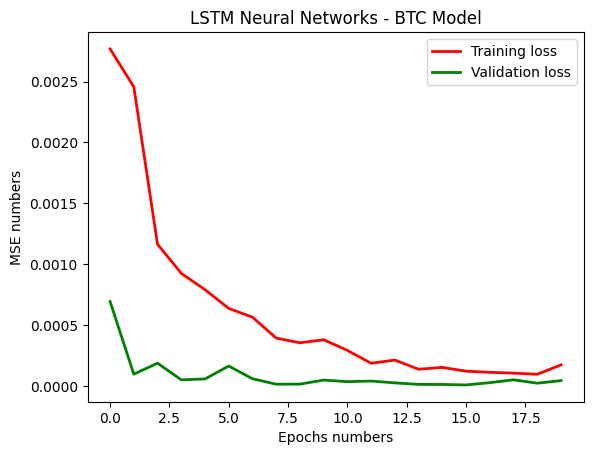

In [23]:
# Plotting the training and validation loss during model training
plt.plot(modelfit.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g', linewidth=2, label='Validation loss')

# Set plot title and axis labels
plt.title('LSTM Neural Networks - BTC Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')

# Display legend to distinguish between training and validation loss
plt.legend()

# Show the plot
plt.show()


In [24]:
# Extract the target values from the test dataset
targets = test_data[aim][window_len:]

# Make predictions using the trained LSTM model on the test data
preds = model.predict(X_test).squeeze()

# Calculate the Mean Absolute Error (MAE) between predictions and actual targets
mae = mean_absolute_error(preds, y_test)

# Display the actual target values
targets.round()


10/10 [==============================] - 1s 2ms/step


Date
2023-10-31 19:06:00    34494.0
2023-10-31 19:07:00    34495.0
2023-10-31 19:08:00    34485.0
2023-10-31 19:09:00    34501.0
2023-10-31 19:10:00    34530.0
                        ...   
2023-10-31 23:56:00    34643.0
2023-10-31 23:57:00    34658.0
2023-10-31 23:58:00    34658.0
2023-10-31 23:59:00    34640.0
2023-11-01 00:00:00    34655.0
Name: Close, Length: 295, dtype: float64

In [25]:
# Calculate the Mean Squared Error (MSE) between predictions and actual targets
SCORE_MSE = mean_squared_error(preds, y_test)

# Display the calculated MSE score
SCORE_MSE


4.4609709220138786e-05

In [26]:
# Calculate the R-squared (R2) score between actual targets and predicted values
r2_score = r2_score(y_test, preds)

# Multiply the R2 score by 100 for percentage representation
r2_score * 100


-4263.336395207454

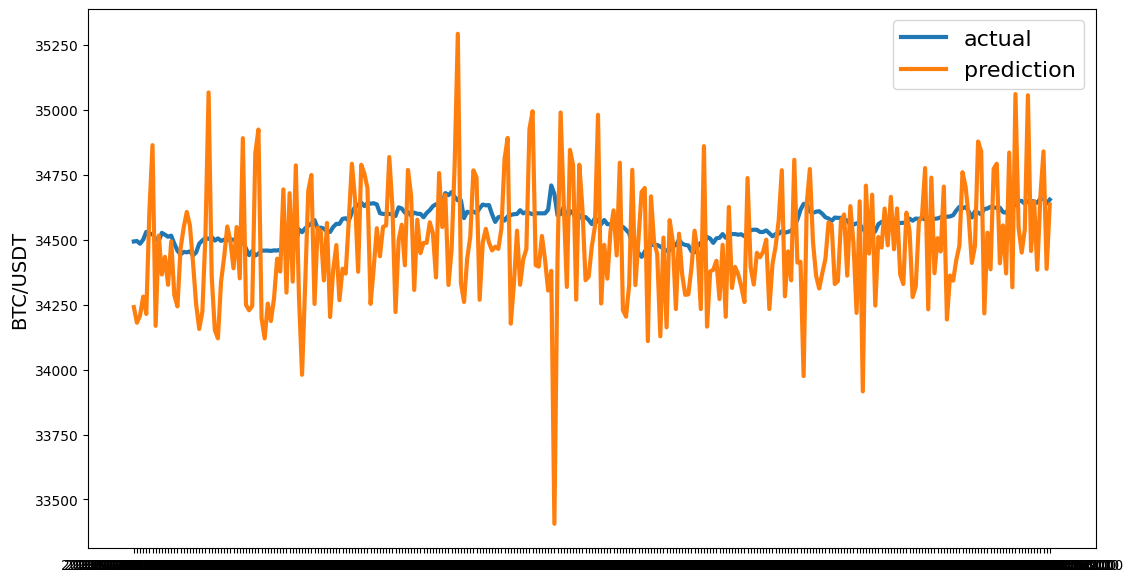

In [27]:
# Generate final predictions by reversing the normalization process
preds = test_data[aim].values[:-window_len] * (preds + 1)

# Create a pandas Series with index and data for predictions
preds = pd.Series(index=targets.index, data=preds)

# Plotting the actual and predicted values
line_plot(targets, preds, 'actual', 'prediction', lw=3)


# 6. Preprocess Data for Binary Classification 

In [28]:
# Assuming 'data' is the DataFrame containing time series data
data['aim_binary'] = (data['Close'] > data['Close'].shift(1)).astype(int)

# Drop NaN values introduced by the shift operation
data = data.dropna()
data.head()


,Open,High,Low,Close,Volume,aim_binary
Date,,,,,,
2023-10-30 23:03:00,34468.03,34468.03,34458.57,34458.58,10.38695,0
2023-10-30 23:04:00,34458.57,34480.95,34458.57,34480.94,15.30814,1
2023-10-30 23:05:00,34480.94,34486.41,34478.05,34486.40,23.63713,1
2023-10-30 23:06:00,34486.40,34491.60,34480.45,34480.45,18.72958,0
2023-10-30 23:07:00,34480.46,34480.46,34480.45,34480.46,5.69870,1


In [29]:
# def prepare_data_binary(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
#     X_train = extract_window_data(train_data[continuous.columns], window_len, zero_base)
#     X_test = extract_window_data(test_data[continuous.columns], window_len, zero_base)
#     y_train = train_data[aim][window_len:].values
#     y_test = test_data[aim][window_len:].values
#     if zero_base:
#         y_train = y_train / train_data[aim][:-window_len].values - 1
#         y_test = y_test / test_data[aim][:-window_len].values - 1

#     return train_data, test_data, X_train, X_test, y_train, y_test


In [30]:
# Prepare data for binary classification
aim_binary = 'aim_binary'
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[aim_binary]), data[aim_binary], test_size=0.2, shuffle=False)


# 7. Binary Classification Model

In [31]:
# Function to build a binary classification model
def build_binary_classification_model(input_data, output_size, neurons, activ_func='sigmoid', dropout=0.3, loss='binary_crossentropy', optimizer='adam'):
    model2 = Sequential()
    # Assuming your time series data has only one feature (e.g., 'Close' column)
    model2.add(LSTM(neurons, input_shape=(X_train.shape[1], 1)))  # Adjust the input shape
    model2.add(Dropout(dropout))
    model2.add(Dense(units=output_size))
    model2.add(Activation(activ_func))
    model2.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model2


In [32]:
# Specify parameters for the binary classification model
binary_lstm_neurons = 50
binary_epochs = 20
batch_size = 32


In [33]:
# Build the binary classification model
binary_model = build_binary_classification_model(X_train, output_size=1, neurons=binary_lstm_neurons)

# Train the binary classification model
binary_modelfit = binary_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=binary_epochs, batch_size=batch_size, verbose=1, shuffle=False)


Epoch 1/20
38/38 [==============================] - 3s 22ms/step - loss: 0.7187 - accuracy: 0.4992 - val_loss: 0.6947 - val_accuracy: 0.4900
Epoch 2/20
38/38 [==============================] - 0s 5ms/step - loss: 0.7080 - accuracy: 0.5109 - val_loss: 0.6961 - val_accuracy: 0.4933
Epoch 3/20
38/38 [==============================] - 0s 4ms/step - loss: 0.7098 - accuracy: 0.5058 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 0s 4ms/step - loss: 0.6970 - accuracy: 0.5259 - val_loss: 0.6944 - val_accuracy: 0.5167
Epoch 5/20
38/38 [==============================] - 0s 5ms/step - loss: 0.7064 - accuracy: 0.5159 - val_loss: 0.6939 - val_accuracy: 0.5033
Epoch 6/20
38/38 [==============================] - 0s 6ms/step - loss: 0.7017 - accuracy: 0.5042 - val_loss: 0.6937 - val_accuracy: 0.5033
Epoch 7/20
38/38 [==============================] - 0s 5ms/step - loss: 0.7070 - accuracy: 0.4900 - val_loss: 0.6929 - val_accuracy: 0.5100
Epoch 8/20
38/38 [=

# 8. Binary Classification 

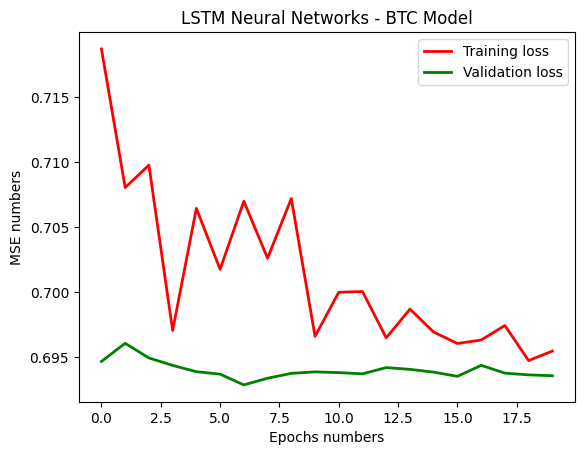

In [34]:
# Plotting the training and validation loss during model training
plt.plot(binary_modelfit.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(binary_modelfit.history['val_loss'], 'g', linewidth=2, label='Validation loss')

# Set plot title and axis labels
plt.title('LSTM Neural Networks - BTC Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')

# Display legend to distinguish between training and validation loss
plt.legend()

# Show the plot
plt.show()


In [35]:
# Make predictions using the trained binary classification model on the test data
binary_preds = (binary_model.predict(X_test) > 0.5).astype(int)

# Extract the binary target values from the test dataset
binary_targets = y_test.astype(int)

# Display the actual binary target values
print("Actual Binary Targets:")
print(binary_targets)

# Display the predicted binary target values
print("Predicted Binary Targets:")
print(binary_preds)


10/10 [==============================] - 1s 9ms/step
Actual Binary Targets:
Date
2023-10-31 19:01:00    1
2023-10-31 19:02:00    0
2023-10-31 19:03:00    0
2023-10-31 19:04:00    0
2023-10-31 19:05:00    1
                      ..
2023-10-31 23:56:00    0
2023-10-31 23:57:00    1
2023-10-31 23:58:00    0
2023-10-31 23:59:00    0
2023-11-01 00:00:00    1
Name: aim_binary, Length: 300, dtype: int64
Predicted Binary Targets:
[[1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]

In [36]:
# Evaluate the binary classification model
binary_preds = (binary_model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_preds)
print(f'Accuracy: {accuracy}')


10/10 [==============================] - 0s 2ms/step
Accuracy: 0.51
